In [88]:
import pandas as pd
import numpy as np
from statsmodels.stats.proportion import proportion_confint
import matplotlib.pyplot as plt
import re

In [89]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 100000)
pd.set_option('display.max_colwidth', None)  

In [90]:
# data = pd.read_csv("objective_annotator_study.csv")
data = pd.read_csv("bias_raw_data.csv")
data.shape

(5, 807)

In [91]:
# TRAIN_PATH = "objective_dataset.csv"
TRAIN_PATH = "TRUE_bias.csv"
train_df = pd.read_csv(TRAIN_PATH)

In [92]:
cols_to_drop = ['StartDate', 'EndDate', 'Status', 'IPAddress', 'Progress',
       'Duration (in seconds)', 'Finished', 'RecordedDate', 'ResponseId',
       'RecipientLastName', 'RecipientFirstName', 'RecipientEmail',
       'ExternalReference', 'LocationLatitude', 'LocationLongitude',
       'DistributionChannel', 'UserLanguage', 'Q_RecaptchaScore', 'Q_RelevantIDDuplicate', 'Q_RelevantIDDuplicateScore',
        'Q_RelevantIDFraudScore',
         'Q_RelevantIDLastStartDate',
         '44_1',
         '47_1',
         '26_1',
         '53_1',
         '37_1',
         'Q60',
         'participantId',
         'assignmentId',
         'projectId',
         'incorrect1',
         'incorrect2',
         'incorrect3',
         'incorrect4',
         'incorrect5',
         'incorrect']

In [93]:
cols_to_drop.extend([col for col in data.columns if col.startswith("Q")])
updated_data_df = data.drop(cols_to_drop, axis=1)

In [94]:
updated_data_df.columns

Index(['MC556412_1', 'MC556412t_First Click', 'MC556412t_Last Click', 'MC556412t_Page Submit', 'MC556412t_Click Count', 'MC587812_1', 'MC587812t_First Click', 'MC587812t_Last Click', 'MC587812t_Page Submit', 'MC587812t_Click Count',
       ...
       'MC574321_1', 'MC574321t_First Click', 'MC574321t_Last Click', 'MC574321t_Page Submit', 'MC574321t_Click Count', 'MC556112_1', 'MC556112t_First Click', 'MC556112t_Last Click', 'MC556112t_Page Submit', 'MC556112t_Click Count'], dtype='object', length=750)

In [95]:
decision_time = {}
num_clicks = {}
for i in range(0, updated_data_df.shape[1], 5):
    question_col = updated_data_df.columns[i]
    assert "First Click" in updated_data_df.columns.values[i + 1]
    assert "Last Click" in updated_data_df.columns.values[i + 2]
    assert "Page Submit" in updated_data_df.columns.values[i + 3]
    assert "Click Count" in updated_data_df.columns.values[i + 4]
    
    first_click = updated_data_df[updated_data_df.columns.values[i + 1]].drop([0,1]).fillna(0).astype(float).sum()
    last_click = updated_data_df[updated_data_df.columns.values[i + 2]].drop([0,1]).fillna(0).astype(float).sum()
    page_submit = updated_data_df[updated_data_df.columns.values[i + 3]].drop([0,1]).fillna(0).astype(float).sum()

    decision_time[question_col] = page_submit-first_click
    num_clicks[question_col] = updated_data_df[updated_data_df.columns.values[i + 4]].drop([0,1]).fillna(0).astype(float).sum()

In [96]:
updated_data_df = updated_data_df.loc[:, ~updated_data_df.columns.str.contains('Click')]
updated_data_df = updated_data_df.loc[:, ~updated_data_df.columns.str.contains('Submit')]

In [97]:
updated_data_df = updated_data_df.drop([0, 1])
updated_data_df = updated_data_df.reset_index(drop=True)
updated_data_df = updated_data_df.fillna(0)
updated_data_df = updated_data_df.astype(int)

In [98]:
non_zero_counts = updated_data_df.apply(np.count_nonzero)
columns_with_only_zeros = non_zero_counts[non_zero_counts < 1].index.tolist()
print(len(columns_with_only_zeros))
updated_data_df = updated_data_df.drop(columns_with_only_zeros, axis=1)

0


In [99]:
columns_with_only_zeros

[]

In [100]:
non_zero_counts = updated_data_df.apply(np.count_nonzero)
columns_with_more_than_one_non_zero = non_zero_counts[non_zero_counts > 1].index.tolist()
print(len(columns_with_more_than_one_non_zero))
updated_data_df = updated_data_df.drop(columns_with_more_than_one_non_zero, axis=1)

0


In [101]:
non_zero_counts_per_row = updated_data_df.apply(np.count_nonzero, axis=1)
filtered_rows = updated_data_df.loc[non_zero_counts_per_row > 50]
filtered_rows.shape

(0, 150)

In [102]:
combined_row = updated_data_df.agg(['sum'])
combined_row = combined_row.reset_index(drop=True)

In [103]:
combined_row.columns

Index(['MC556412_1', 'MC587812_1', 'MC502312_1', 'MC569321_1', 'MC571212_1', 'MC515721_1', 'MC547012_1', 'MC511021_1', 'MC591112_1', 'MC501521_1',
       ...
       'MC548312_1', 'MC589812_1', 'MC542812_1', 'MC574812_1', 'MC546221_1', 'MC550512_1', 'MC543512_1', 'MC534712_1', 'MC574321_1', 'MC556112_1'], dtype='object', length=150)

Likelihood of correctness and average confidence

In [104]:
def calculate_likelihoods(df):
    correctness_counts = {}
    total_counts = {}
    
    for column_name in df.columns:
        tag = column_name[-4:-2]
        preferred_choice = "A" if tag[0] == "1" else "B"
        
        scores = df[column_name].tolist()
        total_counts[tag] = total_counts.get(tag, 0) + len(scores)

        preferred_count = 0
        for score in scores:
            if (preferred_choice == 'A' and 1 <= score <= 4) or (preferred_choice == 'B' and 5 <= score <= 8):
                preferred_count += 1

        correctness_counts[tag] = correctness_counts.get(tag, 0) + preferred_count

    
    likelihood_results = {tag: (correctness_counts[tag] / total_counts[tag]) * 100 for tag in total_counts}
    likelihood_confints = {}
    for tag in total_counts:
        likelihood_confints[tag] = proportion_confint(
            correctness_counts[tag],
            total_counts[tag],
            alpha=0.1,
        )
    
    return likelihood_results, likelihood_confints, total_counts

In [105]:
def normalize_confidence_scores(score):
    if score <= 4:
        return (4 - score) / 3  
    else:
        return (score - 5) / 3  

def calculate_ci(scores, confidence=1.645):
    mean_score = np.mean(scores)
    std_dev = np.std(scores, ddof=1)  
    n = len(scores)
    sem = std_dev / np.sqrt(n)  
    margin_error = sem * confidence
    
    lower_bound = mean_score - margin_error
    upper_bound = mean_score + margin_error
    
    return (lower_bound, upper_bound)

def calculate_normalized_average_confidence(df):
    total_normalized_scores = {}
    normalized_scores_by_tag = {}
    response_counts = {}

    for column_name in df:
        tag = column_name[-4:-2]
        scores = df[column_name].tolist()
        response_counts[tag] = response_counts.get(tag, 0) + len(scores)

        for score in scores:
            normalized_score = normalize_confidence_scores(score)
            total_normalized_scores[tag] = total_normalized_scores.get(tag, 0) + normalized_score
            normalized_scores_by_tag.setdefault(tag, []).append(normalized_score)
    
    average_normalized_scores = {}
    confidence_int = {}
    for tag, total_score in total_normalized_scores.items():
        average_score = total_score / response_counts[tag] if response_counts[tag] > 0 else 0
        average_normalized_scores[tag] = average_score
        ci = calculate_ci(normalized_scores_by_tag[tag], 1.645)  
        confidence_int[tag] = ci
        
    return average_normalized_scores, confidence_int

In [106]:
likelihoods, likelihood_confints, counts_per_category = calculate_likelihoods(combined_row)

In [107]:
average_confidences, confidence_int = calculate_normalized_average_confidence(combined_row)

<Figure size 1000x600 with 0 Axes>

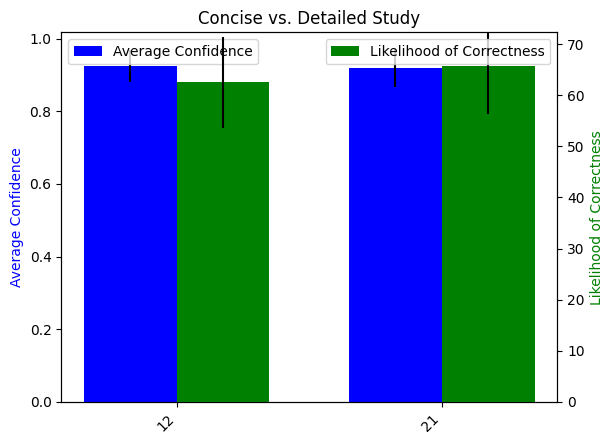

In [108]:
labels = average_confidences.keys()
avg_conf_values = np.array([average_confidences[label] for label in labels])
avg_confint_arr = np.array([confidence_int[label] for label in labels]).transpose()
avg_confint_arr = np.abs(avg_confint_arr - avg_conf_values[None, :])

likelihood_values = np.array([likelihoods[label] for label in labels])
likelihood_confint_arr = np.array([likelihood_confints[label] for label in labels]).transpose()
likelihood_confint_arr = np.abs(likelihood_confint_arr * 100 - likelihood_values[None, :])

x = np.arange(len(labels))
width = 0.35 

plt.figure(figsize=(10, 6))

fig, ax1 = plt.subplots()
rects1 = ax1.bar(x - width/2, avg_conf_values, width, yerr=avg_confint_arr, label='Average Confidence', color='blue')

ax2 = ax1.twinx() 
rects2 = ax2.bar(x + width/2, likelihood_values, width, yerr=likelihood_confint_arr, label='Likelihood of Correctness', color='green')

ax1.set_ylabel('Average Confidence', color='blue')
ax2.set_ylabel('Likelihood of Correctness', color='green')
ax1.set_title('Concise vs. Detailed Study')
ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=45, ha='right', fontsize=10) 

ax1.set_ylim(0, max(avg_conf_values) * 1.1)
ax2.set_ylim(0, max(likelihood_values) * 1.1)

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.savefig("avg_conf_and_likelihood.png")
plt.show()

<Figure size 1000x600 with 0 Axes>

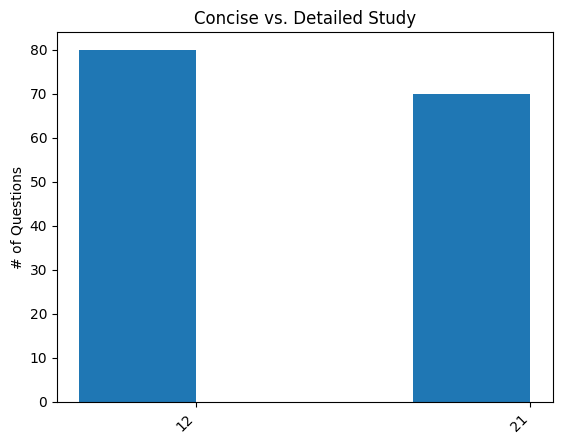

In [109]:
labels = counts_per_category.keys()
x = np.arange(len(labels))
width = 0.35 

total_category_count_values = np.array([counts_per_category[label] for label in labels])

plt.figure(figsize=(10, 6))

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, total_category_count_values, width)

ax.set_ylabel('# of Questions')
ax.set_title('Concise vs. Detailed Study')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=10) 

plt.savefig("total_counts_per_category.png")
plt.show()

In [110]:
likelihoods

{'12': 62.5, '21': 65.71428571428571}

Assign chosen and rejected values for train set

In [111]:
chosen = [None]*train_df.shape[0]
rejected = [None]*train_df.shape[0]
chosen_type = [None]*train_df.shape[0]
rejected_type = [None]*train_df.shape[0]
conf_scores = [None]*train_df.shape[0]
conf_difficulty = [None]*train_df.shape[0]
decision_times = [None]*train_df.shape[0]
number_of_clicks = [None]*train_df.shape[0]
scratch_space_lst = [None]*train_df.shape[0]
prompt_response_lst = [None]*train_df.shape[0]


train_df["chosen"] = chosen
train_df["rejected"] = rejected
train_df["chosen_type"] = chosen_type
train_df["rejected_type"] = rejected_type
train_df["confidence_scores"] = conf_scores
train_df["confidence_difficulty"] = conf_difficulty
train_df["decision_time"] = decision_times
train_df["number_of_clicks"] = number_of_clicks
train_df["scratch_space"] = scratch_space_lst
train_df["prompt_response_group"] = prompt_response_lst

for col in combined_row.columns:
    index = train_df.loc[train_df["MCQ_id"]==col[:-2]].index[0]
    row = train_df.iloc[index]
    score = combined_row[col][0]
    train_df.loc[index, "confidence_scores"] = normalize_confidence_scores(score)
    train_df.loc[index, "confidence_difficulty"] = 1-normalize_confidence_scores(score)
    train_df.loc[index, "raw_number_of_clicks"] = num_clicks[col]
    train_df.loc[index, "raw_decision_time"] = decision_time[col]
    train_df.loc[index, "prompt_response_group"] = f"Prompt: {row['prompt']}\n\nResponse A: {row['choice1']}\n\nResponse B: {row['choice2']}"
    if score <= 4:
        train_df.loc[index, "chosen"] = f"Human: {row['prompt']}\n\nAssistant: {row['choice1']}"
        train_df.loc[index, "rejected"] = f"Human: {row['prompt']}\n\nAssistant: {row['choice2']}"
        train_df.loc[index, "chosen_type"] = row["choice1_type"]
        train_df.loc[index, "rejected_type"] = row["choice2_type"]
    else:
        train_df.loc[index, "chosen"] = f"Human: {row['prompt']}\n\nAssistant: {row['choice2']}"
        train_df.loc[index, "rejected"] = f"Human: {row['prompt']}\n\nAssistant: {row['choice1']}"
        train_df.loc[index, "chosen_type"] = row["choice2_type"]
        train_df.loc[index, "rejected_type"] = row["choice1_type"]


In [112]:
train_df["log_decision_time"] = train_df["raw_decision_time"].apply(lambda x: np.log1p(max(x, 0)))

In [113]:
train_df['decision_time'] = (train_df['raw_decision_time'] - train_df['raw_decision_time'].min()) / (train_df['raw_decision_time'].max() - train_df['raw_decision_time'].min())
train_df['number_of_clicks'] = (train_df['raw_number_of_clicks'] - train_df['raw_number_of_clicks'].min()) / (train_df['raw_number_of_clicks'].max() - train_df['raw_number_of_clicks'].min())

In [114]:
train_df['log_norm_decision_time'] = (train_df['log_decision_time'] - train_df['log_decision_time'].min()) / (train_df['log_decision_time'].max() - train_df['log_decision_time'].min())

In [115]:
train_df["decision_time_beta"] = 1-train_df['decision_time']
train_df["num_clicks_beta"] = 1-train_df["number_of_clicks"]

In [116]:
train_df["confidence_beta"] = 1 - train_df["confidence_difficulty"]

In [117]:
train_df["correct_chosen"] = train_df["chosen_type"] == "correct"

In [119]:
train_df = train_df.dropna(subset=["number_of_clicks"])
train_df.shape

(150, 28)

In [120]:
train_df.to_csv(TRAIN_PATH, index=False)

In [121]:
train_df["number_of_clicks"].dropna().shape

(150,)

In [122]:
train_df.shape

(150, 28)

Per-source correctness and counts

In [27]:
train_df = train_df[train_df["confidence_beta"].notna()]
train_df.shape

(1000, 28)

In [39]:
train_df.groupby("source").size()

source
QuAIL                                        110
abstract_algebra                               4
abstract_narrative_understanding              10
anatomy                                        4
astronomy                                      4
bbq_lite_json                                 10
causal_judgment                               10
checkmate_in_one                              10
clinical_knowledge                             4
code_line_description                         10
college_biology                                4
college_chemistry                              4
college_computer_science                       4
college_mathematics                            4
college_medicine                               4
college_physics                                4
color                                         10
computer_security                              4
conceptual_physics                             4
contextual_parametric_knowledge_conflicts     10
crash_blossom

In [40]:
correct_counts = train_df.groupby("source")["correct_chosen"].sum()
total_counts = train_df.groupby("source")["correct_chosen"].count()
accuracy = correct_counts / total_counts
accuracy

source
QuAIL                                        0.745455
abstract_algebra                             0.500000
abstract_narrative_understanding             1.000000
anatomy                                      0.750000
astronomy                                    0.500000
bbq_lite_json                                0.900000
causal_judgment                              0.700000
checkmate_in_one                             0.400000
clinical_knowledge                           0.750000
code_line_description                        0.700000
college_biology                              0.500000
college_chemistry                            0.250000
college_computer_science                     0.250000
college_mathematics                          0.250000
college_medicine                             0.500000
college_physics                              0.500000
color                                        0.700000
computer_security                            1.000000
conceptual_physics   

In [41]:
train_df.groupby("source")["decision_time"].mean()

source
QuAIL                                        0.061057
abstract_algebra                             0.003854
abstract_narrative_understanding             0.020155
anatomy                                      0.004342
astronomy                                    0.010415
bbq_lite_json                                0.013606
causal_judgment                              0.043610
checkmate_in_one                             0.013854
clinical_knowledge                           0.011465
code_line_description                        0.034202
college_biology                              0.055728
college_chemistry                            0.029319
college_computer_science                     0.015860
college_mathematics                          0.013266
college_medicine                             0.015124
college_physics                              0.068452
color                                        0.034367
computer_security                            0.005188
conceptual_physics   